In [53]:
from pathlib import Path

import matplotlib.pyplot as plt

import seaborn as sns
from tqdm.notebook import tqdm
from collections import namedtuple

from eval import read_run_dir
from new_eval import new_get_run_metrics, get_config, baseline_data, LoadInfo
from plot_utils import basic_plot
from typing import List

%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

#models_dir = Path("../models")
device = "cpu" # Set to "cuda" if needed

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
def plot_collection(load_info_collection: List[LoadInfo], title: str, device: str = "cuda", yhigh_lim: float = float('inf'), baselines: List[str] = None, saveas: Path = None):
    metrics = {}
    for path, step, alt_path, alternative_pretrained_dir, alternative_name, name_addon in load_info_collection:
        conf = get_config(path / "config.yaml")
        name = alternative_name if alternative_name != "" else conf.wandb.name + "/" + conf.training.task + name_addon

        if alternative_pretrained_dir is not None:
            print("Alternative pretrained model dir: ", alternative_pretrained_dir)
            conf.model.pretrained_model_dir = str(alternative_pretrained_dir)

        if alt_path is not None:
            conf.training = get_config(alt_path).training

        #print(conf.model)

        metrics[name] = new_get_run_metrics(conf, path, step=step, include_noise=True, device=device, ground_truth_loss=True)

    if baselines is not None:
        train_conf_path = load_info_collection[0].alternative_train_conf_path if load_info_collection[0].alternative_train_conf_path is not None else load_info_collection[0].path / "config.yaml"
        baseline_mets = baseline_data(train_conf_path, device=device, include_noise=True, ground_truth_loss=True)
        print(baseline_mets.keys())
        metrics.update({key: baseline_mets[key] for key in baselines if key in baseline_mets})
    
    _, ax = basic_plot(metrics, yhigh_lim=yhigh_lim)
    ax.set_title(title)
    #plt.tight_layout()
    if saveas is not None:
        plt.savefig(saveas)
    #plt.tight_layout()
    plt.show()

Device: cpu
Alternative pretrained model dir:  /home/morten/Dokumenter/CS182Project/pos_models/base_model
Device: cpu
Lora Non-tranaible parameters: 7656705
Lora Trainable parameters: 12288 

Device: cpu
Alternative pretrained model dir:  /home/morten/Dokumenter/CS182Project/pos_models/base_model
Device: cpu
SoftPrompt Non-tranaible parameters: 7656705
SoftPrompt Trainable parameters: 12800 

Device: cpu
Device: cpu
dict_keys(['chebyshev_5', 'ridge_chebyshev_5'])


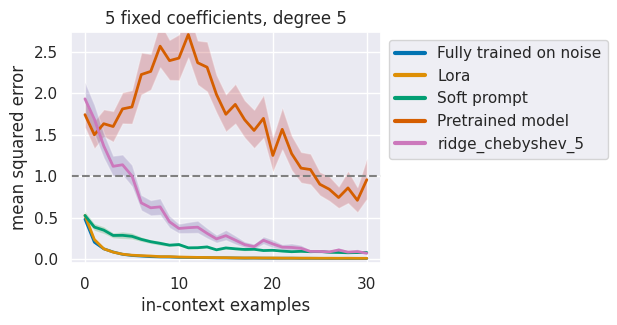

In [55]:
# Compare noisy examples with degree 5 and different sets of fixed coefficients
noisy_dir = Path("../noisy_stuff")
pos_dir = Path("../pos_models")

def plot_noisy_example(i: int, title: str):

    noisy_run = LoadInfo(path=noisy_dir / "full_fine" / f"prompt{i}", step=-1,
                                    alternative_name="Fully trained on noise")
    load_info_collection = [noisy_run,
                            LoadInfo(path=noisy_dir / "lora_rk_4_pos_enc_noise_morten" / f"lora{i}", step=-1,
                                    #alternative_train_conf_path=noisy_run.path / "config.yaml",
                                    alternative_pretrained_path="/home/morten/Dokumenter/CS182Project/pos_models/base_model",
                                    alternative_name="Lora"),
                            LoadInfo(path=noisy_dir / "soft_prompt_noise_morten" / f"prompt{i}", step=-1,
                                    #alternative_train_conf_path=noisy_run.path / "config.yaml",
                                    alternative_pretrained_path="/home/morten/Dokumenter/CS182Project/pos_models/base_model",
                                    alternative_name="Soft prompt"),
                            LoadInfo(path=pos_dir / "base_model", step=-1,
                                    alternative_train_conf_path=noisy_run.path / "config.yaml",
                                    alternative_name="Pretrained model"),
                            ]

    plot_collection(load_info_collection, title=title, device=device, baselines=['ridge_chebyshev_5']) # "chebyshev_5", 
    #plot_collection(load_info_collection, device=device, yhigh_lim=0.2, baselines=["chebyshev_5"])

#plot_noisy_example(6, title="0 fixed coefficients, degree 5")
#plot_noisy_example(7, title="1 fixed coefficient, degree 5")
#plot_noisy_example(9, title="3 fixed coefficients, degree 5")
plot_noisy_example(11, title="5 fixed coefficients, degree 5")